<a href="https://colab.research.google.com/github/arpitakashyap29/Deepfake-detection-using-resnet-50/blob/main/deepfake%20detection%20using%C2%A0resnet%C2%A050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!python -m pip install -qq kaggle

In [ ]:
!kaggle datasets download -d asifmzx/celeb-v1-df

Dataset URL: https://www.kaggle.com/datasets/asifmzx/celeb-v1-df
License(s): MIT
 99% 1.97G/1.98G [00:30<00:00, 103MB/s]
100% 1.98G/1.98G [00:30<00:00, 70.1MB/s]


In [ ]:
!unzip -q celeb-v1-df.zip

In [ ]:
!pip install torch torchvision numpy pandas opencv-python

In [ ]:
!pip install tensorflow numpy pandas opencv-python

In [ ]:
import torch
import torchvision.models as models


model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


In [ ]:
!pip install torch torchvision opencv-python pandas

In [ ]:
test_videos = []
with open('List_of_testing_videos.txt', 'r') as file:
    test_videos = file.read().splitlines()

In [ ]:
import os

real_videos_path = 'Celeb-real'
fake_videos_path = 'Celeb-synthesis'
# Temporary directories for extracted frames
temp_real_frames = 'temp_frames/real'
temp_fake_frames = 'temp_frames/fake'
# Paths for training and testing frames
train_real_images_path = 'train/real/'
train_fake_images_path = 'train/fake/'
test_real_images_path = 'test/real/'
test_fake_images_path = 'test/fake/'


os.makedirs(temp_real_frames, exist_ok=True)
os.makedirs(temp_fake_frames, exist_ok=True)
os.makedirs(train_real_images_path, exist_ok=True)
os.makedirs(train_fake_images_path, exist_ok=True)
os.makedirs(test_real_images_path, exist_ok=True)
os.makedirs(test_fake_images_path, exist_ok=True)

In [ ]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import shutil

def extract_frames(video_path, output_folder, frame_rate=5, similarity_threshold=1000):
    """
    Extract frames from a video file, removing duplicates, and save them to the output folder.

    Args:
    - video_path: str, path to the video file.
    - output_folder: str, path to save the extracted frames.
    - frame_rate: int, number of frames to skip before extracting a new one.
    - similarity_threshold: float, MSE threshold to consider frames as different.
    """
    video = cv2.VideoCapture(video_path)
    count = 0
    success, prev_frame = video.read()  # Read the first frame

    if not success:
        print(f"Failed to read the video file {video_path}")
        return

    # Save the first frame
    frame_filename = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(video_path))[0]}frame{count}.jpg")
    cv2.imwrite(frame_filename, prev_frame)

    while True:
        # Read the next frame
        success, frame = video.read()
        if not success:
            break

        # Skip frames to achieve the desired frame rate
        count += 1
        if count % frame_rate != 0:
            continue

        # Compute the similarity between the current frame and the previous saved frame
        if mse(prev_frame, frame) > similarity_threshold:
            # If different enough, save the frame
            frame_filename = os.path.join(output_folder, f"{os.path.splitext(os.path.basename(video_path))[0]}frame{count}.jpg")
            cv2.imwrite(frame_filename, frame)
            prev_frame = frame  # Update the previous frame

    video.release()
    cv2.destroyAllWindows()

def mse(imageA, imageB):
    """
    Compute the Mean Squared Error between two images.
    The lower the MSE, the more similar the images are.
    """
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [ ]:
for video_file in os.listdir(real_videos_path):
    extract_frames(os.path.join(real_videos_path, video_file), temp_real_frames)

for video_file in os.listdir(fake_videos_path):
    extract_frames(os.path.join(fake_videos_path, video_file), temp_fake_frames)

real_frames = [os.path.join(temp_real_frames, f) for f in os.listdir(temp_real_frames)]
fake_frames = [os.path.join(temp_fake_frames, f) for f in os.listdir(temp_fake_frames)]

# Split frames into training and testing sets (80-20 split)
train_real, test_real = train_test_split(real_frames, test_size=0.2, random_state=42)
train_fake, test_fake = train_test_split(fake_frames, test_size=0.2, random_state=42)

# Move frames to the corresponding train/test directories
for frame in train_real:
    shutil.move(frame, train_real_images_path)
for frame in test_real:
    shutil.move(frame, test_real_images_path)
for frame in train_fake:
    shutil.move(frame, train_fake_images_path)
for frame in test_fake:
    shutil.move(frame, test_fake_images_path)

# Clean up temporary directories
shutil.rmtree(temp_real_frames)
shutil.rmtree(temp_fake_frames)

In [ ]:
def is_test_video(video_file, test_videos_list):
    return video_file in test_videos_list

# Separate videos into training and testing sets
for video_file in os.listdir(real_videos_path):
    video_name = video_file.split('.')[0]
    if is_test_video(video_name, test_videos):
        extract_frames(os.path.join(real_videos_path, video_file), test_real_images_path)
    else:
        extract_frames(os.path.join(real_videos_path, video_file), train_real_images_path)

for video_file in os.listdir(fake_videos_path):
    video_name = video_file.split('.')[0]
    if is_test_video(video_name, test_videos):
        extract_frames(os.path.join(fake_videos_path, video_file), test_fake_images_path)
    else:
        extract_frames(os.path.join(fake_videos_path, video_file), train_fake_images_path)

In [ ]:
import torchvision.transforms as transforms

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize frames to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip frames horizontally
    transforms.ToTensor(),  # Convert frames to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary output: Real vs. Fake

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 117MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler to adjust learning rate over time
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
from torchvision import datasets, transforms
import torch

# Load the training data
train_dataset = datasets.ImageFolder(root='train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Number of epochs to train
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)

    # Step the learning rate scheduler
    scheduler.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/5, Loss: 0.2429
Epoch 2/5, Loss: 0.1020
Epoch 3/5, Loss: 0.0701
Epoch 4/5, Loss: 0.0458
Epoch 5/5, Loss: 0.0416


In [ ]:
test_dataset = datasets.ImageFolder('/content/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the model on the test images: {100 * correct / total:.2f}%")

Accuracy of the model on the test images: 98.94%


Confusion Matrix:
[[2897   26]
 [  20  556]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2923
           1       0.96      0.97      0.96       576

    accuracy                           0.99      3499
   macro avg       0.97      0.98      0.98      3499
weighted avg       0.99      0.99      0.99      3499



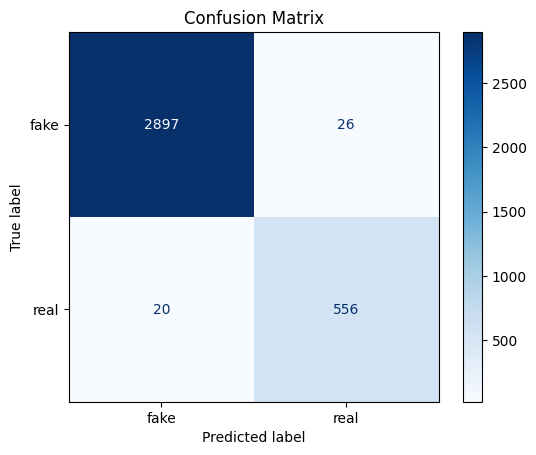

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()
